In [20]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import dask
from scipy.stats import randint
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.metrics import classification_report


In [21]:
# read daily data
processed_dfs = []
for filename in sorted(os.listdir('data/aggregated_individual_data/')):
    with open('data/aggregated_individual_data/'+filename, 'r') as f: # open in readonly mode
        df = pd.read_csv(f)
        df.drop('Unnamed: 0', inplace=True, axis = 1)
        processed_dfs.append(df)

In [22]:
example = processed_dfs[1].copy()
example.head()

,time,weekday,mood,circumplex.arousal,circumplex.valence,activity,screen,call,sms,appCat.builtin,...,appCat.entertainment,appCat.finance,appCat.game,appCat.office,appCat.other,appCat.social,appCat.travel,appCat.unknown,appCat.utilities,appCat.weather
0,2014-03-16,6,6.5,-0.5,0.50,NaN,746.315000,0.0,0.0,116.333,...,0.000,0.0,0.0,0.0,48.325,39.985,0.000,0.0,0.0,NaN
1,2014-03-17,0,6.5,0.5,0.00,0.145299,8669.900001,6.0,0.0,1392.999,...,320.024,0.0,0.0,0.0,128.881,123.806,0.000,0.0,0.0,NaN
2,2014-03-18,1,8.0,0.8,1.00,0.351584,6820.626001,15.0,1.0,2703.184,...,2280.097,0.0,0.0,0.0,89.302,212.871,0.000,0.0,0.0,NaN
3,2014-03-19,2,7.4,0.2,0.60,0.452052,7920.775000,3.0,1.0,1524.853,...,154.147,0.0,0.0,0.0,97.805,51.841,567.165,0.0,0.0,NaN
4,2014-03-20,3,6.5,-0.5,0.25,0.355026,4095.841002,6.0,0.0,1519.766,...,118.799,0.0,0.0,0.0,94.651,94.488,0.000,0.0,0.0,NaN


In [23]:
vars = ['time', 'weekday', 'mood', 'circumplex.arousal', 'circumplex.valence',
       'activity', 'screen', 'call', 'sms', 'appCat.builtin',
       'appCat.communication', 'appCat.entertainment', 'appCat.finance',
       'appCat.game', 'appCat.office', 'appCat.other', 'appCat.social',
       'appCat.travel', 'appCat.unknown', 'appCat.utilities', 'appCat.weather', 'mood_2days', 'mood_yesterday', '1day_mood_change', 'mood_target', 'target_bw' ]

forest_data = pd.DataFrame(columns = vars)

n_days = 5

for i, df_org in enumerate(processed_dfs):
    df = df_org.copy()

    for j, col in enumerate(example.columns[2:len(vars)]):
        df[col] = (df[col]-df[col].min())/(df[col].max() - df[col].min())
        df[col] = df[col].fillna(0)
        
    for j in range(len(df)-n_days-1):
        means = pd.DataFrame(df.iloc[j:j+n_days, 2:len(example.columns)].mean())
        forest_data = pd.concat([forest_data, means.transpose()], ignore_index=True)
        forest_data.iloc[-1, 0] = df['time'].iloc[j+n_days+1]
        forest_data.iloc[-1, 1] = df['weekday'].iloc[j+n_days+1]
        forest_data.iloc[-1, -5] = df['mood'].iloc[j+n_days-1]
        forest_data.iloc[-1, -4] = df['mood'].iloc[j+n_days]
        forest_data.iloc[-1, -2] = df['mood'].iloc[j+n_days+1]


# delete columns with too many nan or 0 values
for col in forest_data.columns:
    if (sum(forest_data[col] == 0)/len(forest_data[col])) > 0.5:
        forest_data = forest_data.drop(col, axis = 1)

forest_data['target_bw'] = forest_data['mood_target'] - forest_data['mood_yesterday']
forest_data['1day_mood_change'] = forest_data['mood_yesterday'] - forest_data['mood_2days']

<Axes: >

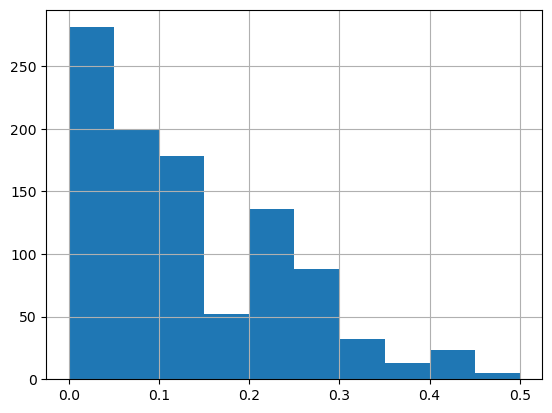

In [24]:
forest_data['sms'].hist()

In [25]:
# labels = ['vl', 'l', 'm', 'h', 'vh']
# # build classes
# for i, col in enumerate(forest_data.columns[2:len(vars)]):
#     forest_data[col+'class'] = pd.cut(forest_data[col], 5, labels=labels)

In [26]:
forest_data.head()

,time,weekday,mood,circumplex.arousal,circumplex.valence,activity,screen,call,sms,appCat.builtin,...,appCat.entertainment,appCat.other,appCat.social,appCat.travel,appCat.utilities,mood_2days,mood_yesterday,1day_mood_change,mood_target,target_bw
0,2014-03-27,3,0.295455,0.782222,0.43,0.489925,0.383056,0.38,0.10,0.065004,...,0.068468,0.096459,0.434987,0.170016,0.153470,0.545455,0.272727,-0.272727,0.545455,0.272727
1,2014-03-28,4,0.309091,0.764444,0.46,0.492840,0.423441,0.26,0.10,0.043903,...,0.060816,0.077870,0.420881,0.056621,0.117417,0.272727,0.545455,0.272727,0.272727,-0.272727
2,2014-03-29,5,0.345455,0.728889,0.51,0.558113,0.591388,0.24,0.10,0.052188,...,0.084745,0.071502,0.501566,0.057861,0.134449,0.545455,0.272727,-0.272727,1.0,0.727273
3,2014-03-30,6,0.327273,0.657778,0.51,0.537830,0.598358,0.34,0.10,0.170968,...,0.110122,0.104798,0.507858,0.198205,0.202164,0.272727,1.0,0.727273,0.772727,-0.227273
4,2014-03-31,0,0.527273,0.551111,0.71,0.505415,0.508903,0.22,0.15,0.165192,...,0.120416,0.120220,0.368342,0.152699,0.257994,1.0,0.772727,-0.227273,0.636364,-0.136364


In [27]:
# delete constant columns
# forest_data = forest_data.loc[:, (forest_data != forest_data.iloc[0]).any()] 
# len(forest_data.columns)

In [28]:
wood = ['weekday', 'mood',
       'activity', 'screen', 'call', 'sms', 'mood_2days', 'mood_yesterday', '1day_mood_change']

# X = forest_data.loc[:, wood].copy()
X = forest_data.iloc[:,1:-2].copy()

#labels = ['vl', 'l', 'ml', 'm', 'mh', 'h', 'vh']
labels = ['vl', 'l', 'm', 'h', 'vh']
#labels = ['l', 'm', 'h']
#labels = ['three', 'four', 'five', 'six', 'seven', 'eight', 'nine']
# y = pd.cut(forest_data['mood_target'], 5, labels=labels)
# y = y.to_numpy()
y = forest_data.loc[:, 'mood_target'].copy()

(array([ 48.,  33.,  66.,  94., 121., 218., 122., 154.,  80.,  71.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

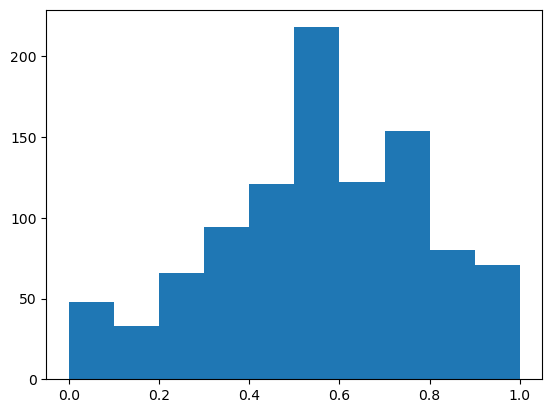

In [29]:
plt.hist(y)

In [30]:
forest_data.iloc[:,1:-2].head()

,weekday,mood,circumplex.arousal,circumplex.valence,activity,screen,call,sms,appCat.builtin,appCat.communication,appCat.entertainment,appCat.other,appCat.social,appCat.travel,appCat.utilities,mood_2days,mood_yesterday,1day_mood_change
0,3,0.295455,0.782222,0.43,0.489925,0.383056,0.38,0.10,0.065004,0.435025,0.068468,0.096459,0.434987,0.170016,0.153470,0.545455,0.272727,-0.272727
1,4,0.309091,0.764444,0.46,0.492840,0.423441,0.26,0.10,0.043903,0.520438,0.060816,0.077870,0.420881,0.056621,0.117417,0.272727,0.545455,0.272727
2,5,0.345455,0.728889,0.51,0.558113,0.591388,0.24,0.10,0.052188,0.596909,0.084745,0.071502,0.501566,0.057861,0.134449,0.545455,0.272727,-0.272727
3,6,0.327273,0.657778,0.51,0.537830,0.598358,0.34,0.10,0.170968,0.554781,0.110122,0.104798,0.507858,0.198205,0.202164,0.272727,1.0,0.727273
4,0,0.527273,0.551111,0.71,0.505415,0.508903,0.22,0.15,0.165192,0.453118,0.120416,0.120220,0.368342,0.152699,0.257994,1.0,0.772727,-0.227273


In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [32]:
# Hyperparameter tuning
param_dist = {'n_estimators': randint(10,100),
              'max_depth': randint(1,15)}

# Create a random forest classifier
rf = RandomForestRegressor(n_jobs = -1)

# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(rf, 
                                 param_distributions = param_dist, 
                                 n_iter=100)

# Fit the random search object to the data
rand_search.fit(X_train, y_train)

RandomizedSearchCV(estimator=RandomForestRegressor(n_jobs=-1), n_iter=100,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x157fadd50>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x157f39ad0>})

In [33]:
best_rf = rand_search.best_estimator_
print('Best hyperparameters:',  rand_search.best_params_)

Best hyperparameters: {'max_depth': 13, 'n_estimators': 78}


In [34]:
rf = RandomForestRegressor(max_depth = 5, n_estimators = 50, n_jobs = -1)
#rf = best_rf

In [35]:
rf = rf.fit(X_train, y_train)

In [36]:
y_pred = rf.predict(X_test)
y_train_pred = rf.predict(X_train)

In [37]:
from sklearn.metrics import mean_squared_error
MSE_test = mean_squared_error(y_test,y_pred)
MSE_train = mean_squared_error(y_train,y_train_pred)
print(MSE_test)
print(MSE_train)

0.04498158957287442
0.029897949978788012


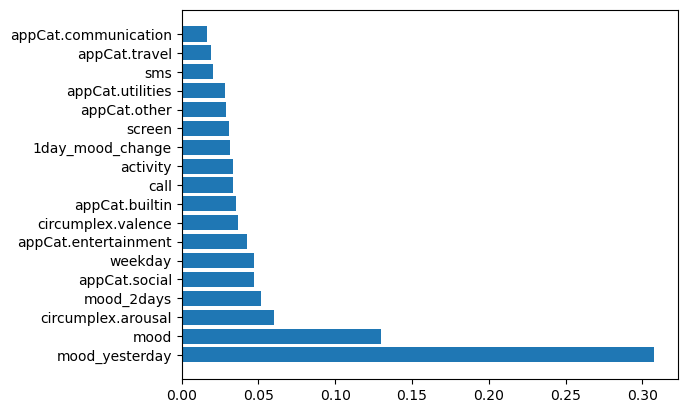

In [38]:
feature_importances = pd.DataFrame(rf.feature_importances_,
                                   index = X_train.columns,
                                   columns=['importance']).sort_values('importance',ascending=False)

fig = plt.figure()
plt.barh(feature_importances.index,feature_importances.importance)

plt.show()
#fig.savefig('rf_importance.pdf')